# 线性滤波模型

In [18]:
import warnings
warnings.filterwarnings('ignore')

## 小波滤波

In [19]:
import pywt # pip install PyWavelets
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [20]:
print(pywt.families()) # 小波族
for family in pywt.families():  #打印出每个小波族的每个小波函数
    print('%s family: '%(family) + ','.join(pywt.wavelist(family)))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
haar family: haar
db family: db1,db2,db3,db4,db5,db6,db7,db8,db9,db10,db11,db12,db13,db14,db15,db16,db17,db18,db19,db20,db21,db22,db23,db24,db25,db26,db27,db28,db29,db30,db31,db32,db33,db34,db35,db36,db37,db38
sym family: sym2,sym3,sym4,sym5,sym6,sym7,sym8,sym9,sym10,sym11,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20
coif family: coif1,coif2,coif3,coif4,coif5,coif6,coif7,coif8,coif9,coif10,coif11,coif12,coif13,coif14,coif15,coif16,coif17
bior family: bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,bior3.7,bior3.9,bior4.4,bior5.5,bior6.8
rbio family: rbio1.1,rbio1.3,rbio1.5,rbio2.2,rbio2.4,rbio2.6,rbio2.8,rbio3.1,rbio3.3,rbio3.5,rbio3.7,rbio3.9,rbio4.4,rbio5.5,rbio6.8
dmey family: dmey
gaus family: gaus1,gaus2,gaus3,gaus4,gaus5,gaus6,gaus7,gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1,cgau2,cgau3,cgau4,cgau5,cgau6,cgau7,cga

In [21]:
def WaveletFilter(single_factor, wavelet, levels):
    # wavelet 小波对象或名称字符串
    # 要使用的小波，小波基函数名称或是小波基函数对象；
    # model string, optional
    # 边界处理方式；信号扩展方式。'zero', 'constant', 'symmetric', 等方式
    # level int, optional
    # 分解的层数；（必须大于0）。默认使用dwt_max_level函数计算。
    # axis: int, optional
    # 沿着哪一个轴进行分解。如果没有给出，则使用最后一个轴。
    coefficients = pywt.wavedec(single_factor, wavelet, level=levels)
    # coefficients是一个列表，包含了每一层分解的系数。其中，第一个元素为逼近系数（低频信号），后面的元素则是一些细节系数（高频信号）。
    filtered_coeffs = coefficients[:1] + [None] * (len(coefficients) - 1) # 去掉高频
    return pywt.waverec(filtered_coeffs, wavelet)

In [22]:
single_factor = [7,2,3,4,15,6,7,-8,9,10]
wavelet            = 'sym2'
levels             = 1
reconstructed_single_factor = WaveletFilter(single_factor, wavelet, levels)

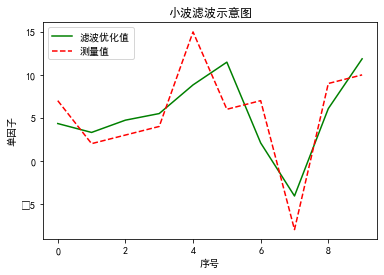

In [23]:
plt.rcParams['font.sans-serif'] = ['SimHei']    # 设置正常显示中文
plt.plot(reconstructed_single_factor, "g", label='滤波优化值')
plt.plot(single_factor, "r--", label='测量值')
plt.xlabel("序号")                                # 设置X轴的名字
plt.ylabel("单因子")                                # 设置Y轴的名字
plt.title("小波滤波示意图")                      # 设置标题
plt.legend()                                      # 设置图例
plt.show()                                        # 显示图表

In [24]:
reconstructed_single_factor

array([ 4.33822142,  3.30472777,  4.73205081,  5.5       ,  8.83493649,
       11.48205081,  2.08253175, -4.08910162,  6.07924682, 11.86931033])

## 卡尔曼滤波

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
import math
# 获得一个数最大整除数
def get_max_divisor(N):
    for i in range(N-1,0,-1):
        if N%i ==0:
            return i
    return 1

In [27]:
def KalmanFilter(single_factor):
    max_divisor = get_max_divisor(len(single_factor))
    delta_t = 1 / max_divisor                       # 每秒钟采一次样
    time_t =len(single_factor)                      # 采样次数
    end_t = len(single_factor)/max_divisor         # 时间长度

    t = np.arange(0, end_t, delta_t)              # 设置时间数组
    v_var = 1                                     # 测量噪声的方差
    v_noise = np.round(np.random.normal(0, v_var, time_t), 2)# 定义测量噪声
    a=1                                           #加速度
    vn=np.add(single_factor , v_noise)       # 定义仪器测量的位置
    v=a*t  #定义速度数组
    a1=np.linspace(a,a,time_t)

    x = np.mat([vn,v,a1])                         # 定义状态矩阵
    u = 0                                         # 定义外界对系统作用矩阵
    A = np.mat([[1, delta_t, 1/2*delta_t], [0, 1, delta_t], [0, 0, 1]])          # 定义状态转移矩阵
    B = 0                                         # 定义输入控制矩阵
    P = np.mat([[1, 0,0], [0, 1,0],[0,0,1]])      # 定义初始状态协方差矩阵
    Q = np.mat([[0.001, 0,0], [0, 0.001,0],[0,0,0.001]])        # 定义状态转移(预测噪声)协方差矩阵
    H = np.mat([1, 0, 0])                         # 定义观测矩阵
    R = np.mat([1])                               # 定义观测噪声协方差矩阵
    xr = np.shape(x)[0]                     # 调用状态矩阵行数
    xc = np.shape(x)[1]                     # 调用状态矩阵列数
    X_mat = x.copy()                        # 初始化记录系统优化状态值的矩阵(浅拷贝）
    X = x.T[0].T                            # 抽取预测优化值的初始状态值
    Z = H * x
    for i in range(1,xc):
        # 预测
        X_predict = A * X                   # 估算状态变量
        if B!=0:
            X_predict = A * X + B * u.T[i-1].T
        P_predict = A * P * A.T + Q         # 估算状态误差协方差
        # 校正
        K = P_predict * H.T / (H * P_predict * H.T + R)  # 更新卡尔曼增益
        X = X_predict + K * (Z.T[i].T - H * X_predict)  # 更新预测优化值
        P = (np.eye(xr) - K * H) * P_predict  # 更新状态误差协方差
        # 记录系统的预测优化值
        for j in range(xr):
            X_mat[j, i] = X[j, 0]
    Z_mat = H * X_mat
    return Z_mat,t,x

In [28]:
single_factor = [7,2,3,4,15,6,7,-8,9,10]
kf,t,x=KalmanFilter(single_factor)
reconstructed_single_factor = np.array(kf)[0]

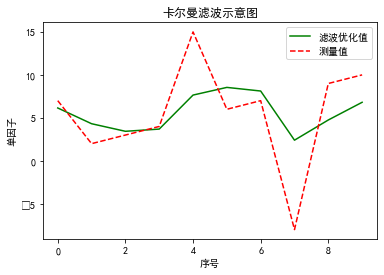

In [29]:
plt.rcParams['font.sans-serif'] = ['SimHei']    # 设置正常显示中文
plt.plot(reconstructed_single_factor, "g", label='滤波优化值')
plt.plot(single_factor, "r--", label='测量值')
plt.xlabel("序号")                                # 设置X轴的名字
plt.ylabel("单因子")                                # 设置Y轴的名字
plt.title("卡尔曼滤波示意图")                      # 设置标题
plt.legend()                                      # 设置图例
plt.show()                                        # 显示图表

In [30]:
reconstructed_single_factor

array([6.15      , 4.31812774, 3.43684639, 3.69384059, 7.65111278,
       8.54448456, 8.12271621, 2.4027916 , 4.7532448 , 6.81128717])

## 高斯滤波

In [31]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [32]:
def GaussianFilter(single_factor, sigma):
    return gaussian_filter1d(single_factor, sigma)

In [33]:
single_factor = [7,2,3,4,15,6,7,-8,9,10]
# sigma 控制高斯滤波器的平滑程度 较大的sigma值将产生更平滑的输出
sigma = 1
reconstructed_single_factor = GaussianFilter(single_factor, sigma)

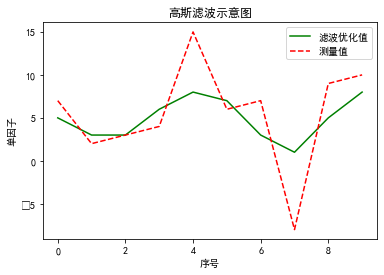

In [34]:
plt.rcParams['font.sans-serif'] = ['SimHei']    # 设置正常显示中文
plt.plot(reconstructed_single_factor, "g", label='滤波优化值')
plt.plot(single_factor, "r--", label='测量值')
plt.xlabel("序号")                                # 设置X轴的名字
plt.ylabel("单因子")                                # 设置Y轴的名字
plt.title("高斯滤波示意图")                      # 设置标题
plt.legend()                                      # 设置图例
plt.show()                                        # 显示图表

In [35]:
reconstructed_single_factor

array([5, 3, 3, 6, 8, 7, 3, 1, 5, 8])